In [ ]:
# Install necessary packages

%pip install tensorflow==2.17.0
%pip install keras==3.4.1
%pip install tf_keras==2.17.0
%pip install numpy==1.26.4
%pip install scikit-learn==1.3.2
%pip install matplotlib==3.7.1
%pip install joblib==1.4.2
%pip install opencv-python==4.10.0.84

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
import joblib

In [2]:
# Define the base directory where images are stored
data_dir = "path/to/data" 

# Define class labels
classes = {'Benign case', 'Malignant case', 'Normal case'}

# Initialize empty lists for images and labels
images = []
labels = []

image_size = 224

# Loop through each class directory
for class_name in classes:
    # Get the path to the current class directory
    class_dir = os.path.join(data_dir, class_name)

    # Loop through each image file in the class directory
    for filename in os.listdir(class_dir):
        # Get the full path to the image file
        image_path = os.path.join(class_dir, filename)

        # Load the image using OpenCV or PIL (adjust as needed)
        image = cv2.imread(image_path)  # Replace with your preferred image loading function
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        # Append the image and its corresponding label to the lists
        images.append(image)
        labels.append(class_name)

label_dict = {"Benign case": 0, "Malignant case": 1, "Normal case": 2}
encoded_labels = [label_dict[label] for label in labels]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.30, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10/(1-0.10), random_state=123)


# Convert lists to NumPy arrays for further processing
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)


print("Training data size:", len(X_train))
print("Testing data size:", len(X_test))
print("Validation data size:", len(X_val))

Training data size: 680
Testing data size: 329
Validation data size: 85


In [3]:
X_train.shape

(680, 224, 224, 3)

In [4]:
X_train, X_test, X_val= X_train / 255.0, X_test / 255.0, X_val / 255.0 # Rescale it to 0-1

In [5]:
from collections import Counter

# Create a dictionary to store class counts
train_class_counts = Counter()

# Count images for each class
for image_path in y_train:
    #class_name = image_path.split("/")[0]
    class_name = str(image_path).split("/")[0]
    train_class_counts[class_name] += 1

# Print the class counts
print("Number of training images per class:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")

Number of training images per class:
0: 162
1: 308
2: 210


In [6]:
# Create a dictionary to store class counts
test_class_counts = Counter()

# Count images for each class
for image_path in y_test:
    class_name = str(image_path).split("/")[0]
    test_class_counts[class_name] += 1

# Print the class counts
print("Number of testing images per class:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Number of testing images per class:
2: 105
1: 141
0: 83


In [7]:
# Create a dictionary to store class counts
test_class_counts = Counter()

# Count images for each class
for image_path in y_val:
    class_name = str(image_path).split("/")[0]
    test_class_counts[class_name] += 1

# Print the class counts
print("Number of validation images per class:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Number of validation images per class:
1: 43
0: 17
2: 25


As observed from the split data, we can conclude that there are imbalance in class

Custom_CNN-RF Model

In [8]:
initializer =keras.initializers.HeNormal(seed = 123) # Weight initializer

cnn_model = keras.models.Sequential([

  keras.layers.Conv2D(filters = 128, kernel_size = (5,5), strides = (2,2), activation = 'relu', input_shape = (image_size, image_size, 3)), # input layer with a convolutional layer

  keras.layers.MaxPool2D(pool_size = (3,3), strides = (2,2)), # maxpooling layer

  # Second convolutional layer
  keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1),padding = 'same', activation = 'relu', kernel_initializer= initializer, 
                      kernel_regularizer = tf.keras.regularizers.l2(l=0.01)),

  keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)),

  # Third convolutional layer
  keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu' , kernel_initializer= initializer, 
                      kernel_regularizer = tf.keras.regularizers.l2(l=0.01)),

  keras.layers.MaxPool2D(pool_size = (2,2), strides = (1,1)),

  keras.layers.Flatten(), # flatten the 3D tensors into a 1D vector to feed into the fully connected layer

  # First fully connected layer
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dropout(0.50, seed = 123),

  # Output layer
  keras.layers.Dense(3, activation='softmax') # softmax is used when there are more than 2 classification classes
])

In [9]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 54, 54, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 32)        0

In [10]:
# Model Compilation
learning_rate = 0.001 # step size to take after calculating loss
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # set optimizer and learning rate

cnn_model.compile(
                  loss='sparse_categorical_crossentropy', # loss function use for non numeric multi-class classification
                  optimizer=optimizer,
                  metrics=["accuracy"]
)

history = cnn_model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=20, shuffle = True, batch_size=16)  # Train for 20 epochs with a batch size of 16

Epoch 1/20
43/43 [==============================] - 6s 40ms/step - loss: 2.6115 - accuracy: 0.4382 - val_loss: 1.7824 - val_accuracy: 0.6588
Epoch 2/20
43/43 [==============================] - 1s 21ms/step - loss: 1.6750 - accuracy: 0.5721 - val_loss: 1.3839 - val_accuracy: 0.7176
Epoch 3/20
43/43 [==============================] - 1s 21ms/step - loss: 1.3761 - accuracy: 0.6485 - val_loss: 1.0581 - val_accuracy: 0.8000
Epoch 4/20
43/43 [==============================] - 1s 21ms/step - loss: 1.1327 - accuracy: 0.6985 - val_loss: 0.9155 - val_accuracy: 0.8118
Epoch 5/20
43/43 [==============================] - 1s 21ms/step - loss: 0.9750 - accuracy: 0.7471 - val_loss: 0.7424 - val_accuracy: 0.8235
Epoch 6/20
43/43 [==============================] - 1s 21ms/step - loss: 0.8643 - accuracy: 0.7647 - val_loss: 0.7108 - val_accuracy: 0.8353
Epoch 7/20
43/43 [==============================] - 1s 24ms/step - loss: 0.7522 - accuracy: 0.8191 - val_loss: 0.5577 - val_accuracy: 0.9059
Epoch 8/20
43

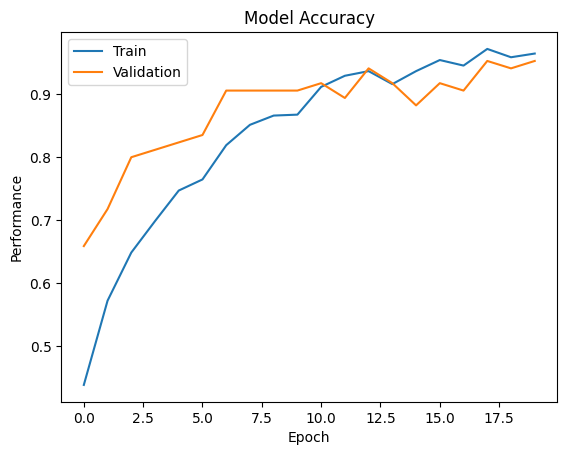

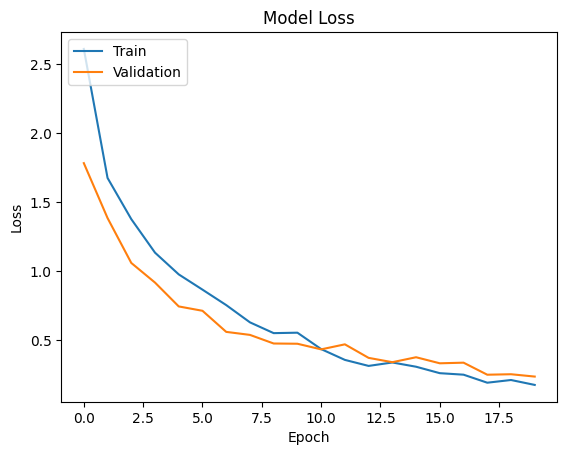

In [11]:
plt.plot(history.history['accuracy']) # plot training accuracy
plt.plot(history.history['val_accuracy']) # plot validation accuracy
plt.title('Model Accuracy') # title of the graph
plt.ylabel('Performance')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show() # construct the plot

plt.plot(history.history['loss']) # plot training loss
plt.plot(history.history['val_loss']) # plot validation loss
plt.title('Model Loss') # title of the graph
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show() # construct the plot

In [12]:
cnn_y_pred = cnn_model.predict(X_test) # predict on test data using the FC
cnn_y_pred = np.argmax(cnn_y_pred, axis = -1)
print(classification_report(y_test, cnn_y_pred)) # check the report

11/11 [==============================] - 1s 46ms/step
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        83
           1       0.97      0.94      0.95       141
           2       0.90      0.90      0.90       105

    accuracy                           0.93       329
   macro avg       0.92      0.93      0.92       329
weighted avg       0.93      0.93      0.93       329



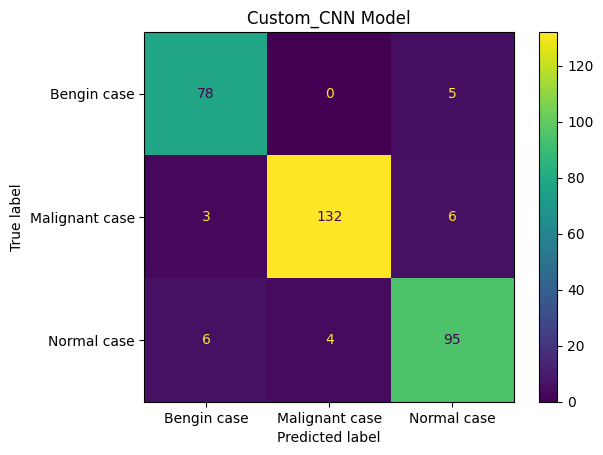

In [13]:
cm = metrics.confusion_matrix(y_test, cnn_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = {'Bengin case':0, 'Malignant case':1, 'Normal case':2})

cm_display.plot()
plt.title("Custom_CNN Model")
plt.show()

In [14]:
input_tensor = cnn_model.get_layer("conv2d").input
model_feat = Model(inputs=cnn_model.input,outputs=cnn_model.get_layer('flatten').output)

In [15]:
model_feat.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 110, 110, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 54, 54, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 32)        18464 

In [16]:
feature_extractor = model_feat.predict(X_train) # extract feature from X_train

22/22 [==============================] - 0s 17ms/step


In [25]:
Rf_X_train = feature_extractor # store it in a new variable to train RF

RF_model = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1, min_samples_split = 2,
                                   max_depth = 100, max_features = 'sqrt', random_state=7)
RF_model.fit(Rf_X_train, y_train) # Training the RF model with the extracted feature

RandomForestClassifier(random_state=7)

In [26]:
# Extract features from test data
Rf_X_test = model_feat.predict(X_test)

# Make predictions on the test data
Rf_y_pred = RF_model.predict(Rf_X_test)

# Evaluate the model performance (e.g., accuracy)
print(classification_report(y_test, Rf_y_pred))

11/11 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        83
           1       0.91      0.99      0.95       141
           2       0.96      0.89      0.92       105

    accuracy                           0.94       329
   macro avg       0.95      0.93      0.94       329
weighted avg       0.94      0.94      0.94       329



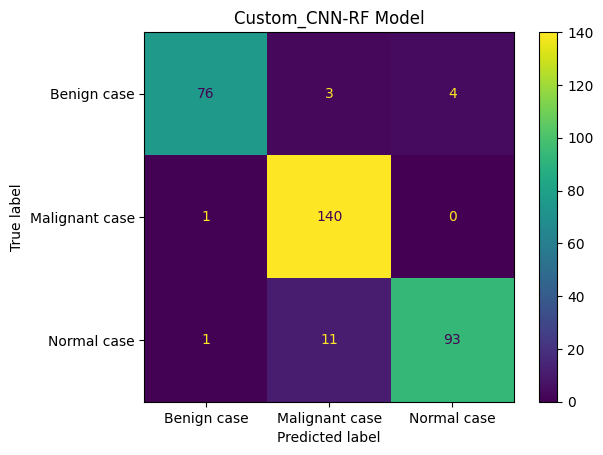

In [27]:
cm = metrics.confusion_matrix(y_test, Rf_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = {'Benign case':0, 'Malignant case':1, 'Normal case':2})

cm_display.plot()
plt.title("Custom_CNN-RF Model")
plt.show()

In [28]:
# Save the model architecture and weights to a HDF5 file
model_feat.save('/path/to/folder/custom_cnn_feature_extractor_finale.h5')
joblib.dump(RF_model, '/path/to/folder/RF_model_finale.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['/content/drive/MyDrive/RF_model_finale.pkl']